# Radiant Environment Maps

Radiant Environment Maps (REMs, also called "light-probes" or "skydomes" in different contexts) define the amount of light (radiance) travelling in all directions at a point in the Earth atmosphere. REMs can be computed using libRadtran with the radiance options ('umu' and 'phi') that allow specification of the directions in which one would like to compute the radiance. Most of the solvers in libRadtran can compute radiances, including all the variants of DISORT. One of the basic capabilities in MORTICIA is to compute REMs and then to compute ("render") the appearance of targets in a specific radiant environment. This notebook illustrates the computation of REMs using libRadtran.

libRadtran has a number of k-distribution (also called "correlated-k") atmospheric absorption parametrizations. These models allow for more rapid computation of radiances and irradiances, but with limited spectral resolution. One such model for the shortwave spectrum is that by Kato et. al. For the thermal spectrum, there is the Fu parametrization. Read the libRadtran manual for more details. Here, we will use the Kato model to compute the sky/ground appearance as provided by a REM.

The MORTICIA class used for REM computation is morticia.rad.librad.RadEnv.

In [1]:
import morticia.rad.librad as librad
# Use auto reload of librad for development purposes
%load_ext autoreload
%autoreload 1
%aimport morticia.rad.librad
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from dask.distributed import Client  # This is the client class for contacting the hub/controller
import xarray as xr
import dill

%matplotlib inline

In [2]:
# Load a libRadtran example case
# Be default, any include files are expanded, creating a single set of option keywords
libRadCaseA=librad.Case(filename='./examples/UVSPEC_AEROSOL_1WVL.INP')
libRadCaseA.alter_option(['albedo', '0.5'])
libRadCaseA.alter_option(['phi0', '0.0'])
libRadCaseA.alter_option(['wavelength', '500.0'])
libRadCaseA.alter_option(['zout', 'boa','0.5', '5.0', 'toa'])
libRadCaseA.alter_option(['number_of_streams', '32'])
libRadCaseA.alter_option(['pseudospherical', ''])
libRadCaseA.alter_option(['zout_interpolate'])
libRadCaseB=librad.Case(filename='./examples/UVSPEC_AEROSOL_1WVL.INP')
libRadCaseB.alter_option(['albedo', '0.5'])
libRadCaseB.alter_option(['phi0', '45.0'])


In [3]:
# Build a radiant environment map case
libRadEnvh = librad.RadEnv(base_case=libRadCaseA, n_pol=256, n_azi=128, hemi=True, n_sza=70)
libRadEnvf = librad.RadEnv(base_case=libRadCaseB, n_pol=256, n_azi=256, hemi=False)

In [4]:
# Connect to the dask.distributed scheduler
paraclient = Client('146.64.246.94:8786')

In [5]:
%time libRadEnvh.run_dask_parallel(dask_client=paraclient, purge=True)

Wall time: 16.9 s


In [6]:
%time libRadEnvf.run_dask_parallel(dask_client=paraclient, purge=True)

Wall time: 24.3 s


In [7]:
dill.dump(libRadEnvh, open( "libRadEnvh.dill", "wb" ))
dill.dump(libRadEnvf, open( "libRadEnvf.dill", "wb" ))

In [10]:
# Alternatively, load them from a file
with open("libRadEnvh.dill", 'rb') as in_strm:
     libRadEnvh = dill.load(in_strm)
with open("libRadEnvf.dill", 'rb') as in_strm:
     libRadEnvf = dill.load(in_strm)        

In [17]:
# Fit spherical harmonics to the REM
N = 4
# %time shh = libRadEnvh.sph_harm_fit(degree=N, method='trapz')
shh = libRadEnvh.sph_harm_fit(degree=N, method='trapz')
# %time shf = libRadEnvf.sph_harm_fit(degree=N, method='trapz')
shf = libRadEnvf.sph_harm_fit(degree=N, method='trapz')

In [18]:
# Print out the spherical harmonic coefficients
for n in range(N+1):
    for m in range(n+1):
        print 'n = ', n, '  m = ', m, ' :  ', shh[n][m].mean().data, '   ', shf[n][m].mean().data

n =  0   m =  0  :   529.286960757     (2.93264243+0j)
n =  1   m =  0  :   165.149379602     (-0.542351142793+0j)
n =  1   m =  1  :   64.672896184     (0.183645776881+0.183645729217j)
n =  2   m =  0  :   0.271448848044     (0.314299598529+0j)
n =  2   m =  1  :   -70.1914007674     (-0.247422868907-0.247422752692j)
n =  2   m =  2  :   28.4698922854     (9.37342560135e-09+0.0940696389223j)
n =  3   m =  0  :   -59.7592932712     (-0.0472363852249+0j)
n =  3   m =  1  :   40.2362435747     (0.188950419941+0.188950246368j)
n =  3   m =  2  :   -31.3910280389     (-4.28873161994e-08-0.143179029429j)
n =  3   m =  3  :   9.3997602176     (-0.022669568144+0.022669581717j)
n =  4   m =  0  :   9.93883461801     (-0.0712707432575+0j)
n =  4   m =  1  :   -22.4521146461     (-0.0973453926519-0.0973452151454j)
n =  4   m =  2  :   26.5760014058     (8.25331601334e-08+0.137907009662j)
n =  4   m =  3  :   -14.1077719073     (0.0402633676093-0.0402634199437j)
n =  4   m =  4  :   3.56067313343

In [7]:
# Compute path transmittances and radiances
libRadEnvh.compute_path_transmittance()
libRadEnvh.compute_path_radiance()

In [11]:
# Take a look at optical depth data
libRadEnvh.xd_opt_depth
# It is a function of propagation zenith angle (PZA), wavelength and
# height (zout).

<xarray.DataArray (pza: 256, wvl: 1, zout: 4)>
array([[[-0.      ,  0.111185,  0.316677,  0.154737]],

       [[-0.      ,  0.111311,  0.317036,  0.154913]],

       ..., 
       [[ 0.111311,  0.317036,  0.154913, -0.      ]],

       [[ 0.111185,  0.316677,  0.154737, -0.      ]]])
Coordinates:
  * pza      (pza) float64 3.142 3.129 3.117 3.105 3.092 3.08 3.068 3.055 ...
  * wvl      (wvl) float64 500.0
  * zout     (zout) float64 0.0 0.5 5.0 inf

Text(0.5,1,u'Path Segment Optical Depth at Height (zout) of 0.5 km, Wavelength of 500.0 nm.')

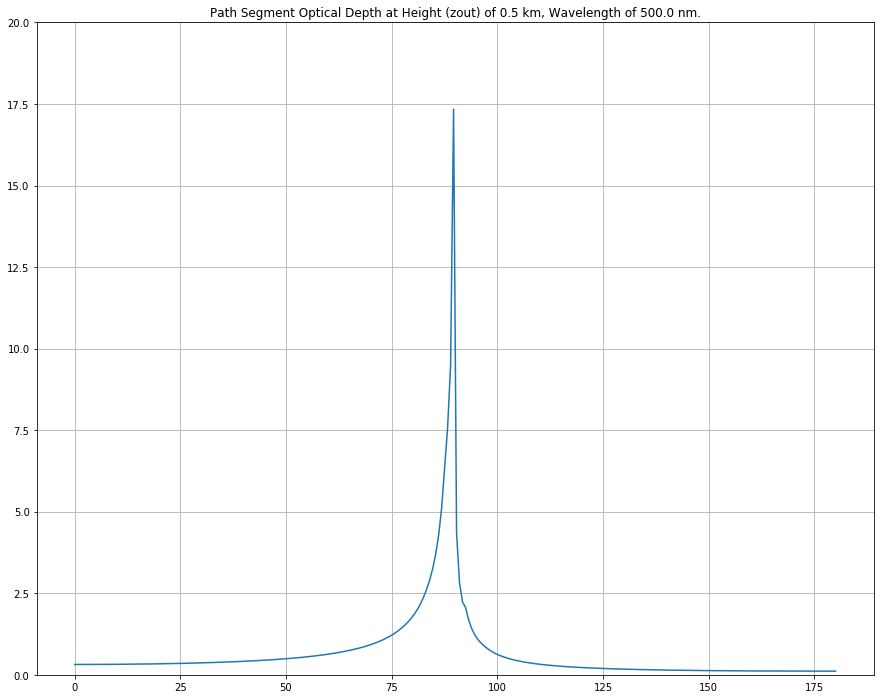

In [20]:

# Plot the path segment optical depths as a function of 
# propagation zenith angle in degrees
izout = 1  # Select a height
zout = libRadEnvh.xd_opt_depth['zout'][izout].data
iwvl = 0  # Select a wavelength
wvl = libRadEnvh.xd_opt_depth['wvl'][iwvl].data
plt.figure(figsize=(15, 12))
plt.plot(np.rad2deg(libRadEnvh.xd_opt_depth['pza'].data), 
         libRadEnvh.xd_opt_depth[:,:,izout].data)
plt.grid()
plt.ylim([0.0,20])
#plt.xlim([0.0, 90.0])
plt.title('Path Segment Optical Depth at Height (zout) of ' + str(zout) + ' km' +
         ', Wavelength of ' + str(wvl) + ' nm.')

(0.0, 10.0)

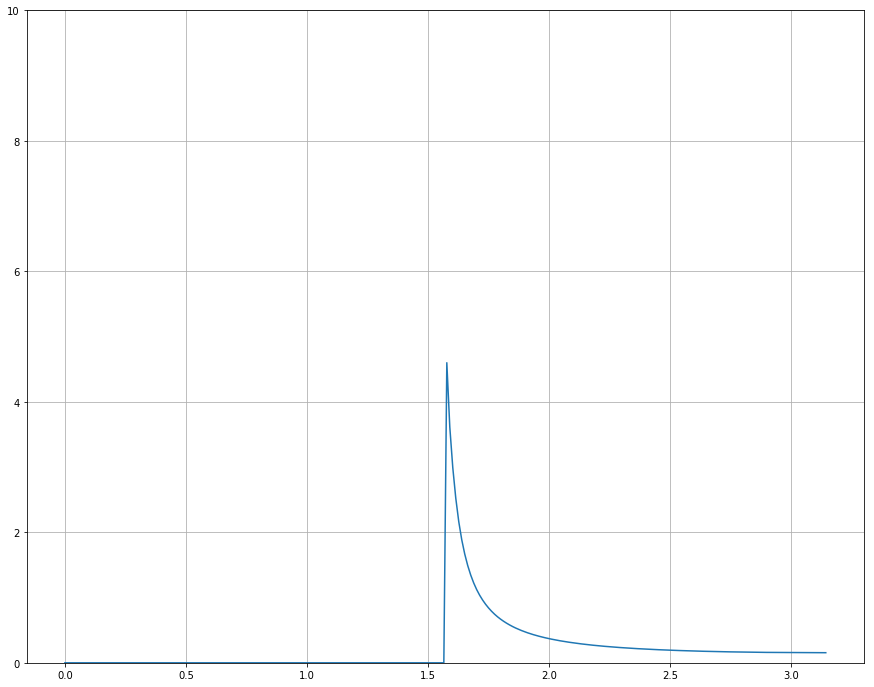

In [21]:
plt.figure(figsize=(15, 12))
plt.plot(libRadEnvh.xd_opt_depth['pza'].data, libRadEnvh.xd_opt_depth[:,0,3].data)
plt.grid()
plt.ylim([0.0,10.0])

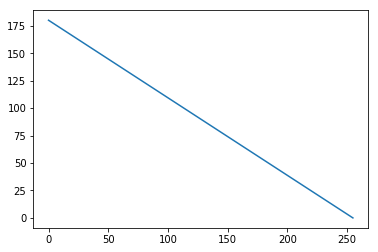

In [57]:
plt.plot(np.rad2deg(libRadEnvh.xd_opt_depth['pza'].data))

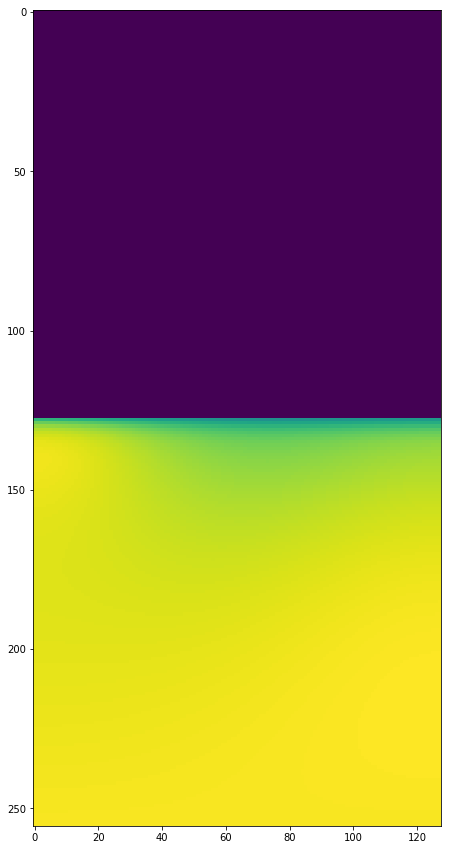

In [58]:
plt.figure(figsize=(10, 15))
plt.imshow(libRadEnvh.xd_uu[:,:,0,3,0])


In [28]:
libRadEnvh.xd_uu.dims


('pza', 'paz', 'wvl', 'zout', 'stokes')

In [29]:
libRadEnvh.xd_uu_times_tau.dims

('pza', 'wvl', 'zout', 'paz', 'stokes')

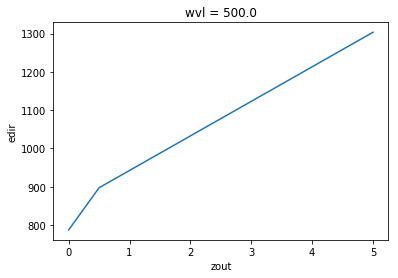

In [59]:
libRadEnvh.xd_edir.plot()

In [31]:
libRadEnvh.xd_opt_depth

<xarray.DataArray (pza: 256, wvl: 1, zout: 4)>
array([[[-0.      ,  0.111185,  0.316677,  0.154737]],

       [[-0.      ,  0.111406,  0.317313,  0.155052]],

       ..., 
       [[ 0.111406,  0.317313,  0.155052, -0.      ]],

       [[ 0.111185,  0.316677,  0.154737, -0.      ]]])
Coordinates:
  * pza      (pza) float64 3.142 3.129 3.117 3.105 3.092 3.08 3.068 3.055 ...
  * wvl      (wvl) float64 500.0
  * zout     (zout) float64 0.0 0.5 5.0 inf

<function matplotlib.pyplot.colorbar>

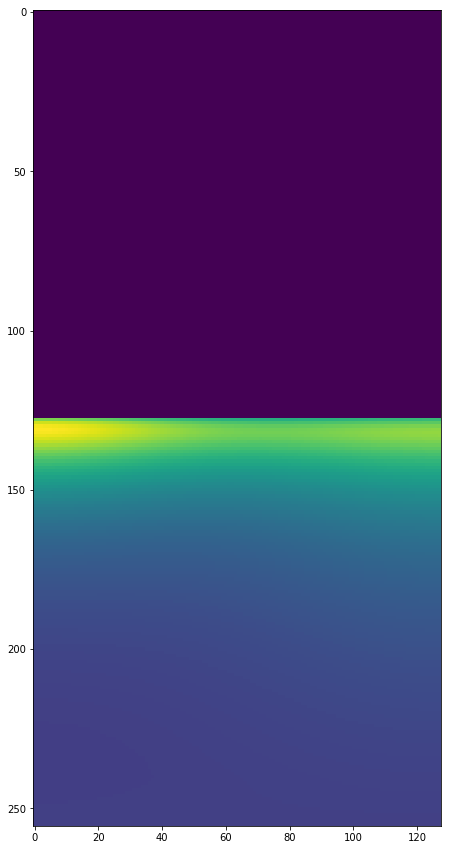

In [60]:
plt.figure(figsize=(15, 15))
plt.imshow(libRadEnvh.xd_path_radiance[:,:,0,3,0])
plt.colorbar

(0.0, 1.1)

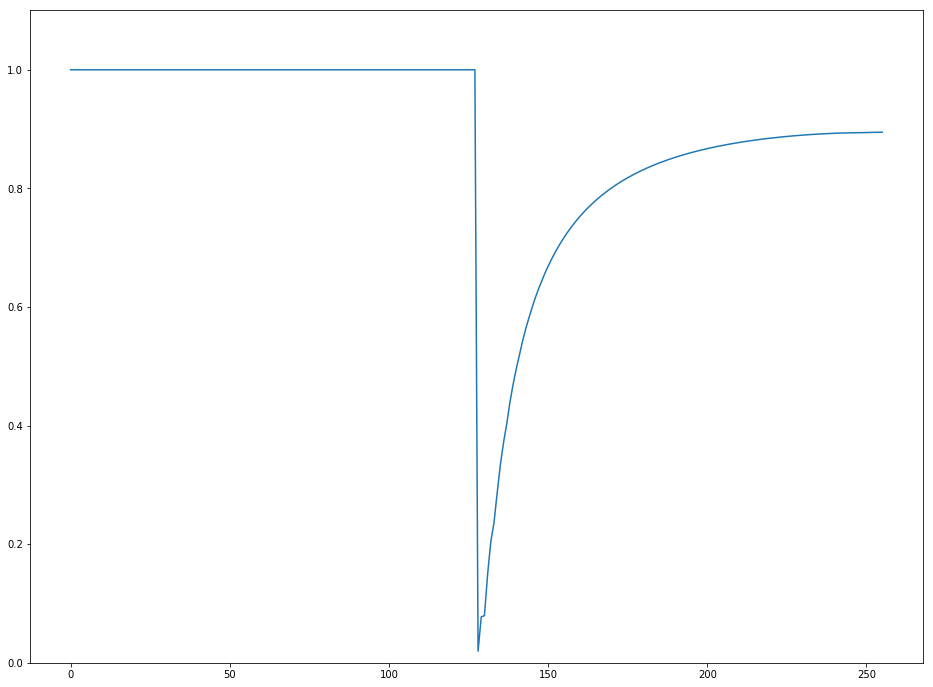

In [61]:
plt.figure(figsize=(16,12))
plt.plot(libRadEnvh.xd_trans[:,0,0])
plt.ylim([0.0, 1.1])

In [66]:
# Load up a base case using the Fu parametrization
# Be default, any include files are expanded, creating a single set of option keywords
libRadCaseThermFu=librad.Case(filename='./examples/UVSPEC_FULIOU.INP')
libRadCaseThermFu.alter_option(['source', 'thermal'])
libRadCaseThermFu.alter_option(['sza', '45.0'])
libRadCaseThermFu.alter_option(['phi0', '0.0'])
libRadCaseThermFu.alter_option(['sur_temperature', '0.0'])
libRadCaseThermFu.alter_option(['wavelength_index', '5', '7'])
libRadCaseThermFu.alter_option(['output_process', 'per_nm'])
libRadCaseThermFu.alter_option(['zout', 'boa','0.5', '1.0', 'toa'])

# Create a solar spectrum case using Fu
libRadCaseSolFu=librad.Case(filename='./examples/UVSPEC_FULIOU_THERMAL.INP')
libRadCaseSolFu.alter_option(['source', 'solar', '../data/solar_flux/fu'])
libRadCaseSolFu.alter_option(['sza', '45.0'])
libRadCaseSolFu.alter_option(['albedo', '0.5'])
libRadCaseSolFu.alter_option(['phi0', '0.0'])
libRadCaseSolFu.alter_option(['aerosol_default'])
libRadCaseSolFu.alter_option(['zout', 'boa','0.5', '1.0', 'toa'])
libRadCaseSolFu.alter_option(['wavelength_index', '4', '6'])
libRadCaseSolFu.alter_option(['output_process', 'per_nm'])
libRadCaseSolFu.alter_option(['pseudospherical'])


In [67]:
print libRadCaseThermFu
print
print libRadCaseSolFu

atmosphere_file ../examples/KTROP.UVSPEC
source thermal
albedo 0.0
rte_solver disort
number_of_streams 4
sza 45.0
wavelength_index 5 7
mol_abs_param FU
output_process per_nm
quiet 
phi0 0.0
sur_temperature 0.0
zout boa 0.5 1.0 toa

atmosphere_file ../examples/KTROP.UVSPEC
source solar ../data/solar_flux/fu
albedo 0.5
rte_solver disort
number_of_streams 4
wavelength_index 4 6
mol_abs_param FU
quiet 
sza 45.0
phi0 0.0
aerosol_default 
zout boa 0.5 1.0 toa
output_process per_nm
pseudospherical 


In [69]:
# Build some radiant environment maps on these base cases
libRadEnvThermFu = librad.RadEnv(base_case=libRadCaseThermFu, n_pol=512, n_azi=2, hemi=True, n_sza=20)
libRadEnvSolFu = librad.RadEnv(base_case=libRadCaseSolFu, n_pol=512, n_azi=64, hemi=True, n_sza=20)

In [70]:
%time libRadEnvThermFu.run_dask_parallel(dask_client=paraclient, purge=True)

Wall time: 4.11 s


D:\Projects\GitHub\MORTICIA\morticia\rad\librad.py:2311: RuntimeWarning: divide by zero encountered in log
  self.xd_opt_depth = -np.log(self.xd_trans_toa)  # Compute the optical depths from a level to TOA


In [71]:
%time libRadEnvSolFu.run_dask_parallel(dask_client=paraclient, purge=True)

Wall time: 11.7 s


In [42]:
print libRadEnvThermFu.xd_uu.mean(), libRadEnvThermFu.base_case.rad_units
print libRadEnvSolFu.xd_uu.mean(), libRadEnvSolFu.base_case.rad_units

<xarray.DataArray 'specrad' ()>
array(0.00041525308267014306) ['W', 'm^2', 'nm']
<xarray.DataArray 'specrad' ()>
array(0.0012140830895169543) ['W', 'm^2', 'nm']


In [43]:
libRadEnvThermFu.xd_uu

<xarray.DataArray 'specrad' (pza: 512, paz: 2, wvl: 3, zout: 4, stokes: 1)>
array([[[[[  6.738899e-05],
          ..., 
          [  0.000000e+00]],

         ..., 
         [[  1.762701e-03],
          ..., 
          [  0.000000e+00]]],


        [[[  6.738899e-05],
          ..., 
          [  0.000000e+00]],

         ..., 
         [[  1.762701e-03],
          ..., 
          [  0.000000e+00]]]],



       ..., 
       [[[[  0.000000e+00],
          ..., 
          [  1.524143e-05]],

         ..., 
         [[  0.000000e+00],
          ..., 
          [  1.134290e-03]]],


        [[[  0.000000e+00],
          ..., 
          [  1.524143e-05]],

         ..., 
         [[  0.000000e+00],
          ..., 
          [  1.134290e-03]]]]])
Coordinates:
  * wvl      (wvl) float64 3e+03 3.7e+03 4.9e+03
  * zout     (zout) float64 0.0 0.5 1.0 inf
  * stokes   (stokes) int64 0
  * paz      (paz) float64 0.0 3.142
  * pza      (pza) float64 3.142 3.135 3.129 3.123 3.117 3.111 3.105 3.099 .

In [44]:
# Save them for later use if libRadtran is not available
dill.dump(libRadEnvThermFu, open( "libRadEnvThermFu.dill", "wb" ) )
dill.dump(libRadEnvSolFu, open( "libRadEnvSolFu.dill", "wb" ) )


In [72]:
# Normalised RGB exr files can be displayed using Irfanview or mtsgui
libRadEnvSolFu.write_openexr('SolFuRGB', chan_per_exr=3, normalise=True, repeat_azi=1, chan_names='BGR')
libRadEnvThermFu.write_openexr('ThermFuRGB', chan_per_exr=3, normalise=True, repeat_azi=128, chan_names='BGR')

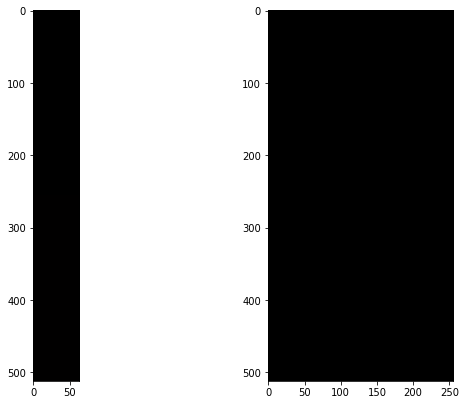

In [46]:
# Plot REMSs for BOA
fig = plt.figure(figsize=(10, 15))
ax1 = fig.add_subplot(221)
ax1.imshow(libRadEnvSolFu.xd_uu[:,:,0:3,0,0])
ax2 = fig.add_subplot(222)
ax2.imshow(np.tile(libRadEnvThermFu.xd_uu[:,:,0:3,0,0], (1,128,1)))


In [47]:
np.tile(libRadEnvThermFu.xd_uu[:,:,0:3,0,0], (1,128,1)).shape

(512L, 256L, 3L)

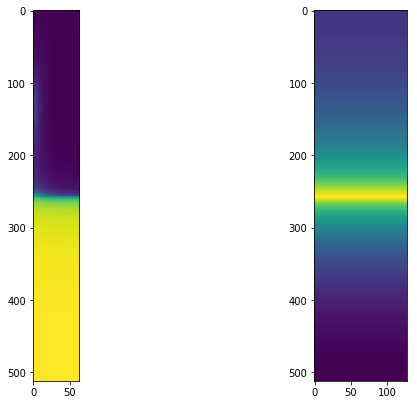

In [48]:
# Plot REMs for 500 m above ground
fig = plt.figure(figsize=(10, 15))
ax1 = fig.add_subplot(221)
ax1.imshow(np.tile(libRadEnvSolFu.xd_uu[:,:,0,1,0], (1,1)))
ax2 = fig.add_subplot(222)
ax2.imshow(np.tile(libRadEnvThermFu.xd_uu[:,:,0,1,0], (1,64)))


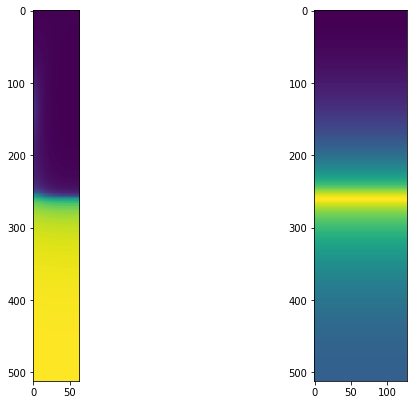

In [49]:
# Plot REMs for 1000 m above ground
fig = plt.figure(figsize=(10, 15))
ax1 = fig.add_subplot(221)
ax1.imshow(np.tile(libRadEnvSolFu.xd_uu[:,:,0,2,0], (1,1)))
ax2 = fig.add_subplot(222)
ax2.imshow(np.tile(libRadEnvThermFu.xd_uu[:,:,0,2,0], (1,64)))


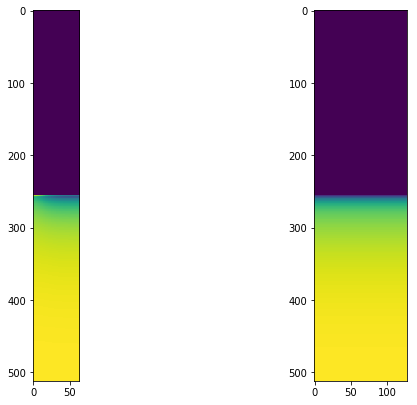

In [50]:
# Plot REMs for TOA
fig = plt.figure(figsize=(10, 15))
ax1 = fig.add_subplot(221)
ax1.imshow(np.tile(libRadEnvSolFu.xd_uu[:,:,0,3,0], (1,1)))
ax2 = fig.add_subplot(222)
ax2.imshow(np.tile(libRadEnvThermFu.xd_uu[:,:,0,3,0], (1,64)))

In [51]:
libRadEnvThermFu.xd_uu.data.shape

(512L, 2L, 3L, 4L, 1L)

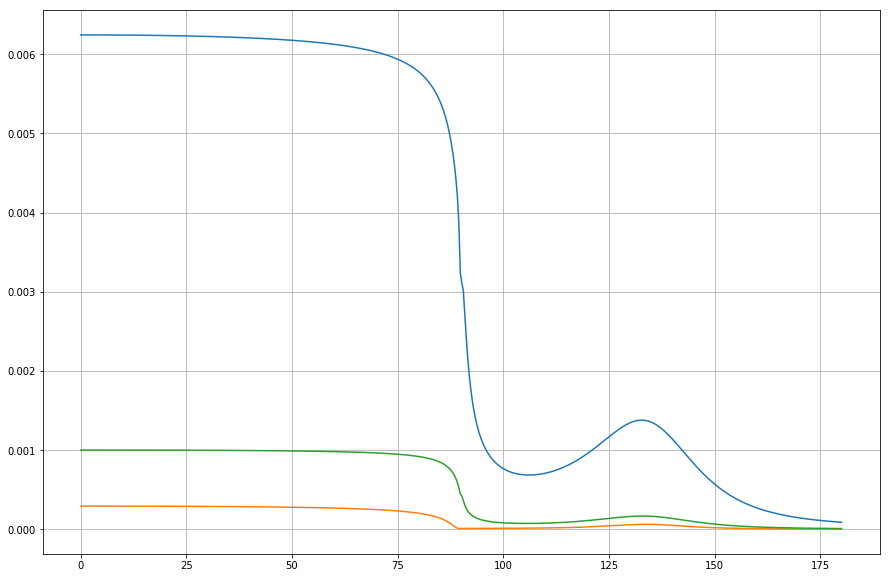

In [52]:
plt.figure(figsize=(15,10))
plt.plot(np.rad2deg(libRadEnvSolFu.xd_uu.pza), libRadEnvSolFu.xd_uu[:,0,:,1,0])
plt.grid()

In [53]:
libRadCaseSolFu.rad_units_str()

'W/sr/m^2/nm'

In [54]:
libRadCaseThermFu.rad_units_str()

'W/sr/m^2/nm'

In [55]:
# Create thermal and solar REPTRAN cases
# Be default, any include files are expanded, creating a single set of option keywords
libRadCaseThermRep=librad.Case(filename='./examples/UVSPEC_REPTRAN_THERMAL_MWIR.INP')
libRadCaseThermRep.alter_option(['aerosol_default'])
libRadCaseThermRep.alter_option(['albedo', '0.5'])
libRadCaseThermRep.alter_option(['wavelength', '2500', '3000'])
libRadCaseThermRep.alter_option(['phi0', '0.0'])
libRadCaseThermRep.alter_option(['zout', '0.05','0.5', '1.0', 'toa'])
libRadCaseThermRep.alter_option(['output_process per_nm'])  # Want radiances per nm bandwidth

libRadCaseSolRep=librad.Case(filename='./examples/UVSPEC_REPTRAN_SOLAR_MWIR.INP')
libRadCaseSolRep.alter_option(['aerosol_default'])
libRadCaseSolRep.alter_option(['albedo', '0.5'])
libRadCaseSolRep.alter_option(['sza', '45.0'])
libRadCaseSolRep.alter_option(['wavelength', '2500', '3000'])
libRadCaseSolRep.alter_option(['phi0', '0.0'])
libRadCaseSolRep.alter_option(['zout', '0.05','0.5', '1.0', 'toa'])



In [56]:
print libRadCaseSolRep
print
print libRadCaseThermRep

rte_solver disort
mol_abs_param reptran coarse
source solar
wavelength 2500 3000
quiet 
aerosol_default 
albedo 0.5
sza 45.0
phi0 0.0
zout 0.05 0.5 1.0 toa

rte_solver disort
mol_abs_param reptran coarse
source thermal
wavelength 2500 3000
quiet 
aerosol_default 
albedo 0.5
phi0 0.0
zout 0.05 0.5 1.0 toa
output_process per_nm 


In [57]:
libRadEnvThermRep = librad.RadEnv(base_case=libRadCaseThermRep, n_pol=128, n_azi=2, hemi=True, n_sza=20)
libRadEnvSolRep = librad.RadEnv(base_case=libRadCaseSolRep, n_pol=128, n_azi=64, hemi=True, n_sza=20)

In [59]:
%time libRadEnvThermRep.run_dask_parallel(dask_client=paraclient, purge=True)

Wall time: 6.49 s


In [60]:
%time libRadEnvSolRep.run_dask_parallel(dask_client=paraclient, purge=True)

Wall time: 37.7 s


In [61]:
print libRadEnvSolRep.xd_uu.shape
print libRadEnvThermRep.xd_uu.shape

(128L, 64L, 45L, 4L, 1L)
(128L, 2L, 45L, 4L, 1L)


In [28]:
# Alternatively reload the saved versions
with open("libRadEnvThermRep.dill", 'rb') as in_strm:
     libRadEnvThermRep = dill.load(in_strm)
with open("libRadEnvSolRep.dill", 'rb') as in_strm:
     libRadEnvSolRep = dill.load(in_strm)

In [62]:
# Save REPTRAN thermal and solar REMs for later use
dill.dump(libRadEnvThermRep, open( "libRadEnvThermRep.dill", "wb" ) )
dill.dump(libRadEnvSolRep, open( "libRadEnvSolRep.dill", "wb" ) )

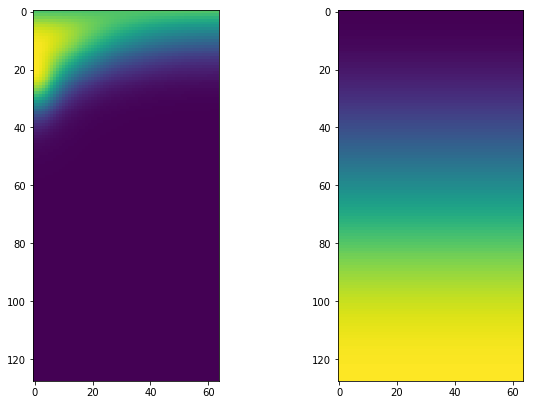

In [63]:
# Plot REMSs for 50 m above ground
fig = plt.figure(figsize=(10, 15))
ax1 = fig.add_subplot(221)
ax1.imshow(libRadEnvSolRep.xd_uu[:,:,6,0,0])
ax2 = fig.add_subplot(222)
ax2.imshow(np.tile(libRadEnvThermRep.xd_uu[:,:,11,0,0], (1,32)))


In [64]:
libRadEnvSolRep.xd_uu.wvl[7]

<xarray.DataArray 'wvl' ()>
array(2572.357)
Coordinates:
    wvl      float64 2.572e+03
Attributes:
    units:      nm
    long_name:  Wavelength

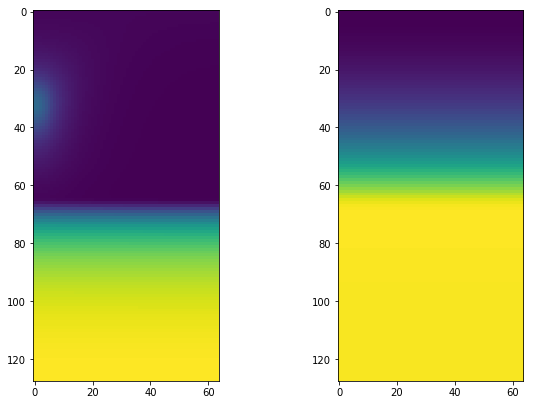

In [65]:
# Plot REMSs for 500 m above ground
fig = plt.figure(figsize=(10, 15))
ax1 = fig.add_subplot(221)
ax1.imshow(np.tile(libRadEnvSolRep.xd_uu[:,:,0,1,0], (1)))
ax2 = fig.add_subplot(222)
ax2.imshow(np.tile(libRadEnvThermRep.xd_uu[:,:,0,1,0], (1,32)))


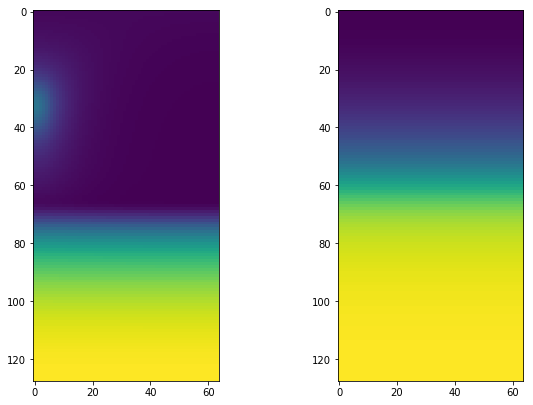

In [66]:
# Plot REMSs for 5000 m above ground
fig = plt.figure(figsize=(10, 15))
ax1 = fig.add_subplot(221)
ax1.imshow(np.tile(libRadEnvSolRep.xd_uu[:,:,0,2,0], (1)))
ax2 = fig.add_subplot(222)
ax2.imshow(np.tile(libRadEnvThermRep.xd_uu[:,:,0,2,0], (1,32)))


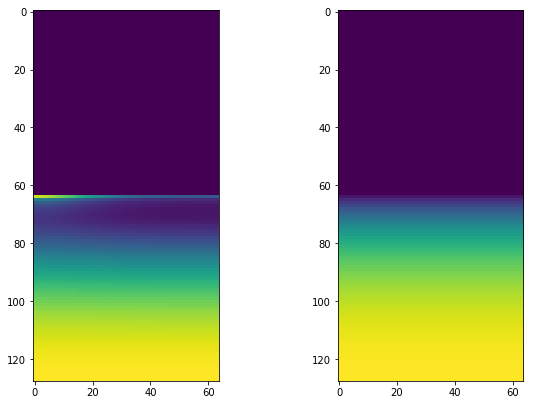

In [67]:
# Plot REMSs for TOA
fig = plt.figure(figsize=(10, 15))
ax1 = fig.add_subplot(221)
ax1.imshow(np.tile(libRadEnvSolRep.xd_uu[:,:,0,3,0], (1)))
ax2 = fig.add_subplot(222)
ax2.imshow(np.tile(libRadEnvThermRep.xd_uu[:,:,0,3,0], (1,32)))


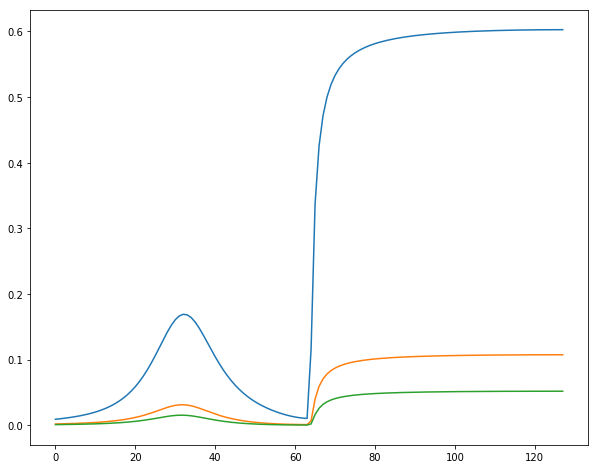

In [68]:
plt.figure(figsize=(10,8))
plt.plot(libRadEnvSolRep.xd_uu[:,0,0:3,0,0])


In [69]:
libRadEnvSolRep.xd_edir.zout

<xarray.DataArray 'zout' (zout: 4)>
array([ 0.05,  0.5 ,  1.  ,   inf])
Coordinates:
  * zout     (zout) float64 0.05 0.5 1.0 inf
Attributes:
    units:      km
    long_name:  Height Above Surface

In [70]:
libRadEnvSolRep.write_openexr('testSol', chan_per_exr=8, normalise=False, repeat_azi=1, use_mitsuba_wvl=True)

In [71]:
libRadEnvSolRep.write_openexr('testSolRGB', chan_per_exr=3, normalise=True, repeat_azi=1, chan_names='BGR')

D:\Projects\GitHub\MORTICIA\morticia\rad\librad.py:2515: RuntimeWarning: invalid value encountered in divide
  chan_data[channel_key] /= chan_max


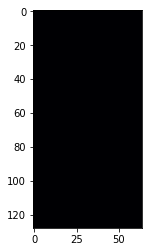

In [72]:
plt.imshow(np.tile(libRadEnvSolRep.xd_uu[:,:,9,0,0], (1,1)), cmap='inferno')

In [73]:
libRadEnvSolRep.xd_uu[:,:,9,0,0].max()

<xarray.DataArray 'specrad' ()>
array(0.0)
Coordinates:
    wvl      float64 2.592e+03
    zout     float64 0.05
    stokes   int64 0

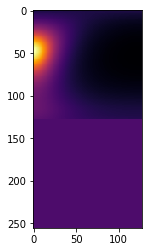

In [74]:
plt.imshow(libRadEnvh.xd_uu[:,:,0,0,0], cmap='inferno')

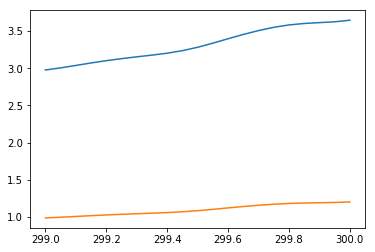

In [75]:


plt.plot(libRadEnvf.xd_edn.wvl, libRadEnvf.xd_edn, libRadEnvf.xd_edn.wvl, libRadEnvf.xd_edir)

In [76]:
str(libRadEnvSolRep.xd_edir[0:3,...])

"<xarray.DataArray 'edir' (wvl: 3, zout: 4)>\narray([[  3.961726,   5.456028,   8.029649,  35.59425 ],\n       [  0.736167,   1.264939,   2.41727 ,  35.05384 ],\n       [  0.361882,   0.683661,   1.483932,  34.80191 ]])\nCoordinates:\n  * wvl      (wvl) float64 2.505e+03 2.514e+03 2.524e+03\n  * zout     (zout) float64 0.05 0.5 1.0 inf\nAttributes:\n    units:      mW/m^2/nm\n    long_name:  Direct Solar Horizontal Irradiance"

In [26]:
libRadEnvh.xd_edir['zout'].data

array([ 0. ,  0.5,  5. ,  inf])